Part 1 - Q3 - LSTM
===

Inspirations:

*  https://www.kaggle.com/code/salls123/simple-lstm-binary-classification
*  https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [ ]:
# from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Dense,LSTM,Dropout,Flatten,BatchNormalization,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.optimizers import  SGD
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import sequence

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [6]:
format_dict = par.create_format_dict()

In [7]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [8]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [9]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_heart_train.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
      dtype='int64', length=188)

In [11]:
df_heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11641 entries, 0 to 11640
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 16.7 MB


In [12]:
n_train_examples = df_heart_train.shape[0]
n_test_examples = df_heart_test.shape[0]
n_total_examples = n_train_examples + n_test_examples
print(f'The test split has {n_test_examples} rows, or {n_test_examples/n_total_examples:.2%} of all examples (which represent {n_total_examples} rows).')

The test split has 2911 rows, or 20.00% of all examples (which represent 14552 rows).


# IMDB Check

In [38]:
from tensorflow.keras.datasets import imdb

In [40]:
# load the dataset but only keep the top n words, zero the rest
top_words = 100
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [41]:
# truncate and pad input sequences
max_review_length = 80
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [42]:
y_train.shape

(25000,)

In [44]:
y_train[:5]

array([1, 0, 0, 1, 0])

In [43]:
X_train.shape

(25000, 80)

In [45]:
# create the model
embedding_vecor_length = 32
model_imdb = Sequential()
model_imdb.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model_imdb.add(LSTM(100))
model_imdb.add(Dense(1, activation='sigmoid'))
model_imdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_imdb.summary())

/home/pinolej/.venv_2/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
model_imdb.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 109s 261ms/step - accuracy: 0.5617 - loss: 0.6773 - val_accuracy: 0.6794 - val_loss: 0.6051
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 132s 338ms/step - accuracy: 0.6685 - loss: 0.6129 - val_accuracy: 0.6874 - val_loss: 0.5880
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 131s 336ms/step - accuracy: 0.6841 - loss: 0.5962 - val_accuracy: 0.6866 - val_loss: 0.5826


In [47]:
print(model_imdb.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 32)         │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,505 (662.13 KB)

 Trainable params: 56,501 (220.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,004 (441.43 KB)

None


# Features preprocessing

In [13]:
import tensorflow as tf

2024-05-19 13:09:02.769511: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 13:09:04.621592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 13:09:08.922044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
tf.random.set_seed(7)

In [73]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [74]:
x_train_0, x_test_0, y_train_0, y_test_0, lstm_input = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=True,
				with_lstm_transfo=True,
)

In [75]:
lstm_input['y_train']

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

# Regular LSTM

## Model Building

In [76]:
def build_model(
	n_neurons=12,
):

	opt = Adam(learning_rate=0.005)

	model = Sequential()
	# model.add(Embedding(total_words, 16, input_length=x_train.shape[1], mask_zero=True))
	# model.add(LSTM(12, dropout=0.7, recurrent_dropout=0.7))
	model.add(LSTM(n_neurons, dropout=0.7, recurrent_dropout=0.7))
	model.add(Dense(6, kernel_regularizer=regularizers.l1_l2(0.3)))
	model.add(Dropout(0.9))
	# model.add(Dense(2, activation='softmax'))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	print(model.summary())
	return model

model_lstm=build_model()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Training

In [77]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history_lstm = model_lstm.fit(
	lstm_input['x_train'],
	lstm_input['y_train'],
	epochs=6,
	batch_size=1000,
	validation_data=(lstm_input['x_test'], lstm_input['y_test']),
	shuffle=False
    )



Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 594ms/step - accuracy: 0.5999 - loss: 7.3628 - val_accuracy: 0.7201 - val_loss: 6.5695
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - accuracy: 0.7199 - loss: 6.3406 - val_accuracy: 0.7201 - val_loss: 5.5947
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 552ms/step - accuracy: 0.7210 - loss: 5.3952 - val_accuracy: 0.7201 - val_loss: 4.6832
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - accuracy: 0.7204 - loss: 4.4932 - val_accuracy: 0.7201 - val_loss: 3.8422
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 0.7207 - loss: 3.6703 - val_accuracy: 0.7201 - val_loss: 3.0602
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - accuracy: 0.7207 - loss: 2.9180 - val_accuracy: 0.7201 - val_loss: 2.4193


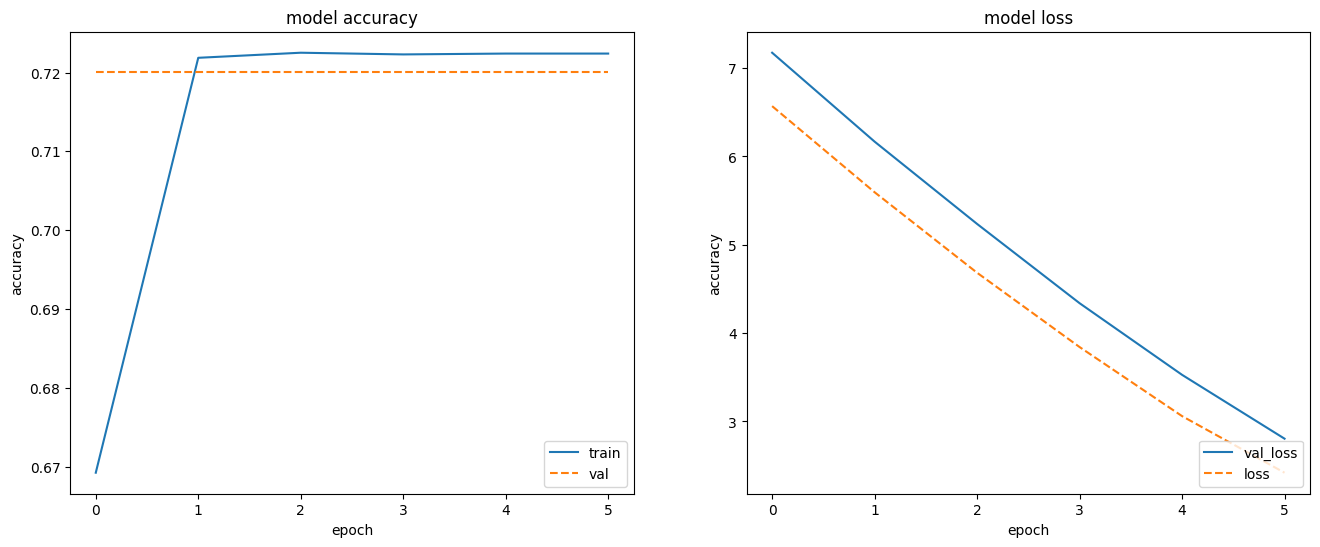

In [78]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history_lstm.history['accuracy'])
axes[0].plot(history_lstm.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history_lstm.history['loss'])
axes[1].plot(history_lstm.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

### Evaluation

#### Predictions performances

In [79]:
_, _, _, _, lstm_input_eval = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=True,
)

In [80]:
y_pred = model_lstm.predict(lstm_input_eval['x_train'])
print(type(y_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step
<class 'numpy.ndarray'>


In [85]:
# import graph as gr
# import params as par
# import py_lib as lib
# reload(gr)
# reload(par)
# reload(lib)
# import graph as gr
# import params as par
# import py_lib as lib

In [86]:
y_pred_tensor, y_pred_round, y_pred_round_tensor = lib.process_for_eval_from_single_proba_array(y_pred)
y_true = torch.from_numpy(lstm_input_eval['y_train'])

In [91]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true, y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [92]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,72.2%,50.0%,83.9%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

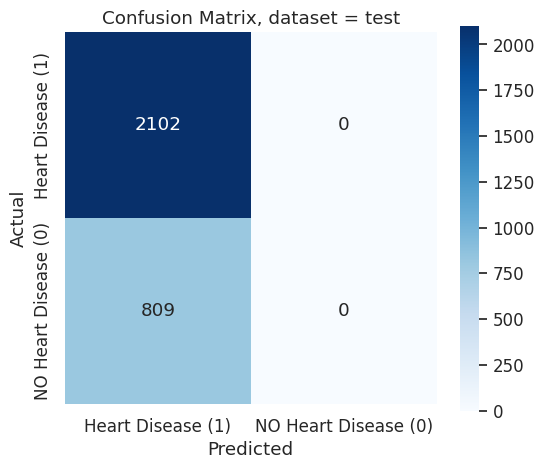

In [93]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [94]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [95]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


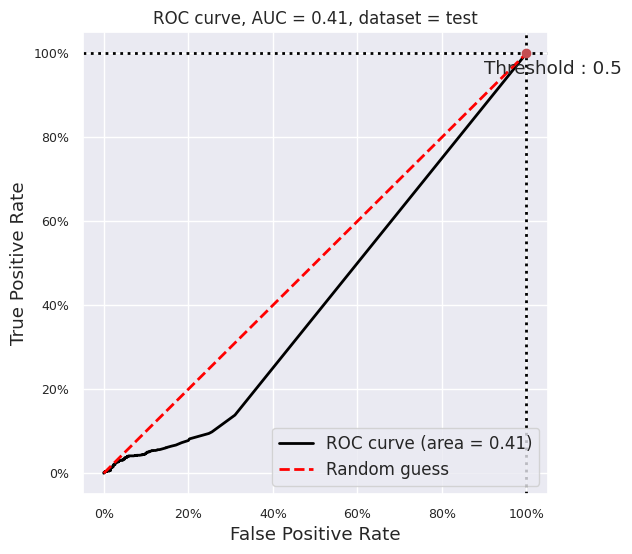

In [96]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)